Unsupervised Learning - Clustering algorithms

# In Depth: Kernel Density Estimation

In the previous section we covered Gaussian mixture models (GMM), which are a kind of hybrid between a clustering estimator and a density estimator. Recall that a density estimator is an algorithm that takes a D-dimensional dataset and produces an estimate of the D-dimensional probability distribution which that data is drawn from. The GMM algorithm accomplishes this by representing the density as a weighted sum of Gaussian distributions. **Kernel density estimation** (KDE) is in some sense an algorithm that takes the mixture-of-Gaussians idea to its logical extreme: it uses a mixture consisting of one Gaussian component **per point**, resulting in an essentially nonparametric estimator of density. In this section, we will explore the motivation and uses of KDE. We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Motivating KDE: Histograms

As already discussed, a density estimator is an algorithm that seeks to model the probability distribution that generated a dataset. For one-dimensional data, you are probably already familiar with one simple density estimator: the histogram. A histogram divides the data into discrete bins, counts the number of points that fall in each bin, and then visualizes the results in an intuitive manner.

For example, let's create some data that is drawn from two normal distributions

In [2]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

We have previously seen that the standard count-based histogram can be created with the `plt.hist()` function. By specifying the `normed` parameter of the histogram, we end up with a normalized histogram where the height of the bins does not reflect counts, but instead reflect probability density:

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


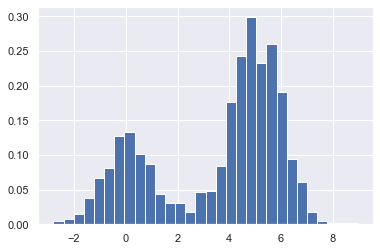

In [3]:
hist = plt.hist(x,bins=30,normed=True)

Notice that for equal binning, this normalization simply changes the scale on the y-axis, leaving heights essentially the same as in a histogram built from counts. This normlization is chosen so that the total area under the hostogram is equal to 1, as we can conform by looking at the output of the histogram function:

In [4]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

One of the issues with using a histogram as a density estimator is that the choice of bin size and location can lead to representations that have qualitatively different features. Fore example, if we look at a version of this data with only 20 points, the choice of how to draw the bins can lead to an entirely different interpretation of the data!

Consider this example:

In [5]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


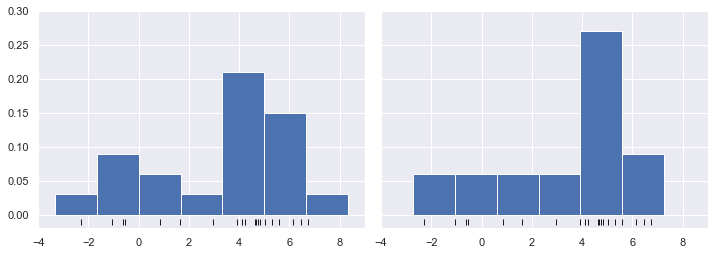

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                       sharex=True, sharey=True,
                       subplot_kw={'xlim':(-4, 9),
                                   'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, normed=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k',
               markeredgewidth=1)

On the left, the histogram makes clear that this is a bimodal distribution. On the right, we see a unimodal distribution with a long trail. Without seeing the preceding code, you would probably not guess that these two histograms were built from the same data. With that in mind, how can you trust the inuition that histograms confer? And how might we improve on this?

Stepping back, we can think of a histogram as a stack of blocks, where we stack one block within each bin on top of each point in the dataset. Let's view this directly:

(-0.2, 8)

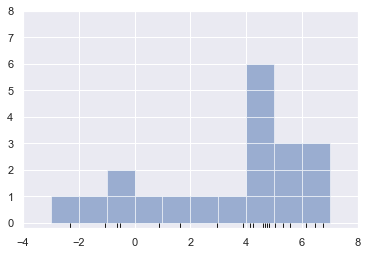

In [7]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k',
        markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1,
                                   alpha=0.5))
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)

The problem with our two binning stems from the fact that the height of the block stack often reflects not on the actual density of points nearby, but on coincidences of how the bins align with the data points. This misalignment between points and their blocks is a potential cause of the poor histogram results seen here. But what if, instead of stacking the blocks aligned with the **bins**, we were to stack the blocks aligned with the **points they represent**? If we do this, the blocks won't be aligned, but we can add their contributions at each location along the x-axis to find the result. Let's try this:

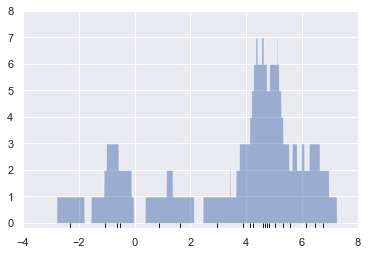

In [8]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8]);

The result looks a bit messy, but is a much more robust reflection of the actual data characteristics than is the standard histogram. Still, the rough edges are not aestetically pleasing, nor are they reflective of any true properties of the data. In order to smooth them out, we might decide to replace the blocks at each location with a smooth function, like a Gaussian. Let's use a standard normal curve at each point instead of a block:

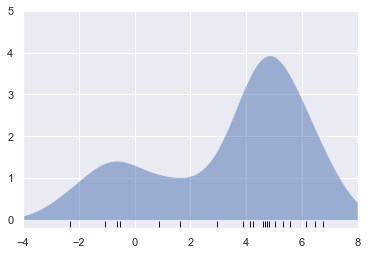

In [9]:
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5]);

This smoothed-out plot, with a Gaussian distribution controbuted at the location of each input point, gives a much more accurate idea of the shape of the data distribution, and one that has much less variance (i.e., changes much less in response to differences in sampling).

These last two plots are examples of kernel density estimation in one dimension: the first uses a so-called "tophat" kernel and the second uses a Gaussian kernel. We'll now look at kernel density estimation in more detail.

## Kernel Density Estimation in Practice

The free oarameters of kernal density estimation are the **kernel**, which specifies the shape of the distribution placed at each point, and the **kernel bandwidth**, which controlls the size of the kernel at each point. In practice, there are many kernels you might use for a kernel density estimation: 

## Example: KDE on a Sphere

## Example: Not-So-Naive Bayes